pp

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

dataset = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(dataset, header=None)

In [4]:
features = data.drop(140, axis=1)
target = data[140]
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]


In [5]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [6]:
class AutoEncoder(Model):
  def __init__(self, output_units, ldim=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(ldim, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [20]:
model = AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(loss='msle', metrics=['mse'], optimizer='adam')
epochs = 20

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 2s 47ms/step - loss: 0.0106 - mse: 0.0239 - val_loss: 0.0138 - val_mse: 0.0324
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0102 - mse: 0.0230 - val_loss: 0.0136 - val_mse: 0.0319
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0096 - mse: 0.0216 - val_loss: 0.0134 - val_mse: 0.0315
Epoch 4/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0087 - mse: 0.0197 - val_loss: 0.0131 - val_mse: 0.0307
Epoch 5/20
5/5 [==============================] - 0s 14ms/step - loss: 0.0079 - mse: 0.0178 - val_loss: 0.0126 - val_mse: 0.0295
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.0071 - mse: 0.0159 - val_loss: 0.0121 - val_mse: 0.0284
Epoch 7/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0064 - mse: 0.0143 - val_loss: 0.0115 - val_mse: 0.0272
Epoch 8/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0059 - mse: 0.0133 - val

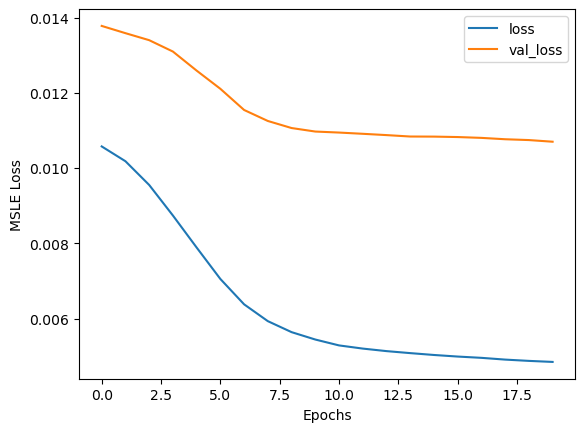

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [22]:
history.history.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

In [9]:
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  threshold = np.mean(reconstruction_errors.numpy()) \
   + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")


73/73 [==============================] - 0s 1ms/step
Threshold: 0.010557753894416252


In [10]:
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

32/32 [==============================] - 0s 1ms/step


0.931